In [1]:
# required imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# for reading in the PyTorchVAE code
import sys
sys.path.insert(0, 'drive/MyDrive/School/cs679/final/PyTorch-VAE')
# sys.path.insert(0, 'drive/MyDrive/School/cs679/final/Data')



from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
Tensor = TypeVar('torch.tensor')
from abc import abstractmethod

# some initial env checks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
class VAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self, in_channels=3, hidden_dims=[32, 64, 128, 256, 512], latent_dim=128,
                 beta: int = 4,
                 gamma:float = 10.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type = "beta",
                 kld_weight_corrector = 1.0):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        self.loss_type = loss_type
        self.kld_weight = kld_weight_corrector

        # Build Encoder
        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
            
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        # kld_weight = 0.00025  # Account for the minibatch samples from the dataset
        kld_weight = self.kld_weight

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'beta': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        else: # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

## Reading in Data & Setting Up Transforms

In [5]:
!gdown 1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ

Downloading...
From: https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ
To: /content/celeba.zip
100% 1.31G/1.31G [00:27<00:00, 47.1MB/s]
Archive:  /content/celeba.zip
   creating: celeba/
  inflating: celeba/img_align_celeba.zip  
  inflating: __MACOSX/celeba/._img_align_celeba.zip  
  inflating: celeba/list_attr_celeba.txt  
  inflating: __MACOSX/celeba/._list_attr_celeba.txt  
  inflating: celeba/.DS_Store        
  inflating: __MACOSX/celeba/._.DS_Store  
  inflating: celeba/list_bbox_celeba.txt  
  inflating: __MACOSX/celeba/._list_bbox_celeba.txt  
  inflating: celeba/list_landmarks_align_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_align_celeba.txt  
  inflating: celeba/list_landmarks_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_celeba.txt  
  inflating: celeba/list_eval_partition.txt  
  inflating: __MACOSX/celeba/._list_eval_partition.txt  
  inflating: celeba/identity_CelebA.txt  
  inflating: __MACOSX/celeba/._identity_CelebA.txt  


In [ ]:
!unzip /content/celeba.zip

In [109]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CelebA
import zipfile
from torchvision.datasets import ImageFolder

# parameters taken from tuned BetaVAE
patch_size = 64
train_batch_size = 16
val_batch_size = 16

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(148),
                                      transforms.Resize(patch_size),
                                      transforms.ToTensor(),])

val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(148),
                                    transforms.Resize(patch_size),
                                    transforms.ToTensor(),])

# IMAGE_PATH = 'drive/MyDrive/School/cs679/final/Data/Data/celeba/img_align_celeba/'
# bypass = ImageFolder(IMAGE_PATH, train_transforms)
train_dataset = MyCelebA(
    "/content",
    split='train',
    transform=train_transforms,
    download=False,
)

val_dataset = MyCelebA(
    '/content',
    split='test',
    transform=val_transforms,
    download=False,
)

def train_dataloader(train_dataset) -> DataLoader:
    return DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        num_workers=1,
        shuffle=True,
        pin_memory=True,
    )

def val_dataloader(val_dataset) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        num_workers=1,
        shuffle=False,
        pin_memory=True,
    )

def test_dataloader(val_dataset) -> Union[DataLoader, List[DataLoader]]:
    return DataLoader(
        val_dataset,
        batch_size=1,
        num_workers=1,
        shuffle=True,
        pin_memory=True,
    )

In [ ]:
!unzip /content/celeba/img_align_celeba.zip -d /content/celeba/

In [110]:
def configure_optimizer(model):
    optimizer = optim.Adam(model.parameters(),
                            lr=5e-4,
                            weight_decay=0.)
    
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                            gamma = 0.95)

    return optimizer, scheduler

In [113]:
# supposed to account for minibatch overweighting
kld_correction = train_batch_size/len(train_dataset)

raw_vae = VAE(in_channels=3, beta=4,
              # loss_type="beta", 
              kld_weight_corrector=.00025)
raw_vae.to(device)

optimizer, scheduler = configure_optimizer(raw_vae)
# train_dl = train_dataloader(train_dataset)

train_dl = train_dataloader(train_dataset)

In [147]:
for epoch in range(2):
    for idx, data in enumerate(tqdm(train_dl, 0)):
        imgs, labels = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        results = raw_vae(imgs)

        train_loss = raw_vae.loss_function(*results)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        train_loss['loss'].backward()
        optimizer.step()
    scheduler.step()

    print('Epoch {}: Loss {}'.format(epoch, train_loss))

100%|██████████| 10174/10174 [05:48<00:00, 29.17it/s]


Epoch 0: Loss {'loss': tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(11.1030, device='cuda:0', grad_fn=<MeanBackward1>)}


100%|██████████| 10174/10174 [05:48<00:00, 29.16it/s]

Epoch 1: Loss {'loss': tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>), 'KLD': tensor(11.2733, device='cuda:0', grad_fn=<MeanBackward1>)}


In [ ]:
test_dl = test_dataloader(val_dataset)

test_input, test_label = next(iter(test_dataloader(val_dataset)))
test_input = test_input.to(device)
test_label = test_label.to(device)

recons = raw_vae.generate(test_input, labels = test_label)

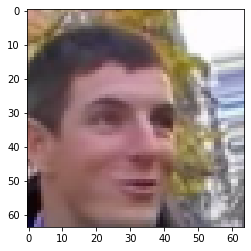

In [168]:
plt.imshow(  test_input[0].cpu().detach().permute(1, 2, 0)  )

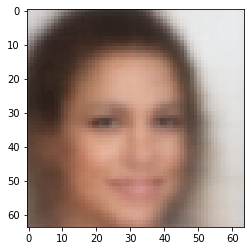

In [169]:
plt.imshow(  recons[0].cpu().detach().permute(1, 2, 0)  )

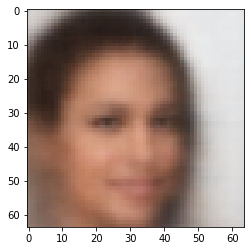

In [194]:
mu, log_var = raw_vae.encode(test_input)
mu[0][0] = mu[0][3] + 0.06
z = raw_vae.reparameterize(mu, log_var)
plt.imshow(  raw_vae.decode(z)[0].cpu().detach().permute(1, 2, 0)  )

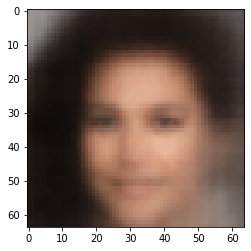

In [154]:
new_perp = raw_vae.sample(1)
plt.imshow(  new_perp[0].cpu().detach().permute(1, 2, 0)  )